# FYSS5120 Efficient Numerical Programming - Demo 5

Author: Felix Cahyadi

Creation date: 11.10.2023

Last changes: 11.10.2023 23:33

First problem: The file measured_data_txt contain three $x$, $y$ values,
| $x$ | $y$ |
|-----|-----|
| 0.1 | 2.1 |
| 1.0 | 3.2 |
| 9.2 | 1.8 |

Write a code that does gaussian process regression to this data set, plot the resulting mean function and 95% confidence limits. You can modify the code sklearn_GPR.py in directory

In  this case, I'm going to modify the code from sklearn_GPR.py

In [73]:
# Import libraries
import sklearn.gaussian_process as gp
import numpy as np
import matplotlib.pyplot as plt

In the first part of the code, we are defining the x array in the range that we are interested in

In [74]:
# Radial Basis Function kernel, aka exponentiated quadratic kernel
# parameters in RBF: length_scale, length_scale_bounds
#                   k(x_i, x_j) = exp(-(x_i-x_j)^2/(2*length_scale))
#
# evaluate result at points X_ext [points, features]
#

x_ext = np.arange(0.1,10.0,0.03)
X_ext = x_ext[:,np.newaxis]

After that, we are defining the kernel for the Gaussian process regressor. In this case, RBF stands for radial basis function. Then create a model, and assign the kernel to that model

In [75]:
# Gaussian process regressor
# --------------------------
kernel = gp.kernels.RBF()
model = gp.GaussianProcessRegressor(kernel=kernel) 

We haven't trained the model yet, if we put the x range that we initialize earlier, the model should return the prior. Here we will see that the prior is y = 0

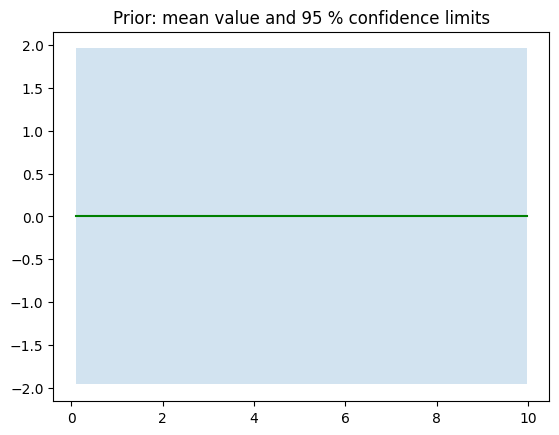

In [76]:
# Prior
# -----
y_prior, std = model.predict(X_ext, return_std=True)
plt.figure(1)
plt.title('Prior: mean value and 95 % confidence limits') 
plt.plot(x_ext,y_prior,'g-')
plt.fill_between(x_ext, y_prior - 1.96*std, y_prior + 1.96*std, alpha=0.2) # 95 % confidence limits 


After that, we are going to define the data points that we want to use for training. The data are listed in the table above

In [77]:
# New data 
# --------

#x_D = np.array([1.0,3.0,6.0,7.0,8.0])
#X_D = x_D[:,np.newaxis]
#y_D = np.sin(x_D)

x_D = np.array([0.1,1.0,9.2])
X_D = x_D[:,np.newaxis]
y_D = np.array([2.1,3.2,1.8])
Y_D = y_D[:,np.newaxis]

After that, using the command model.fit(), we are training the model

score =  1.0
params: {'length_scale': 1.1113630530761676, 'length_scale_bounds': (1e-05, 100000.0)}


Text(0.5, 1.0, 'Posterior: mean value and 95 % confidence limits')

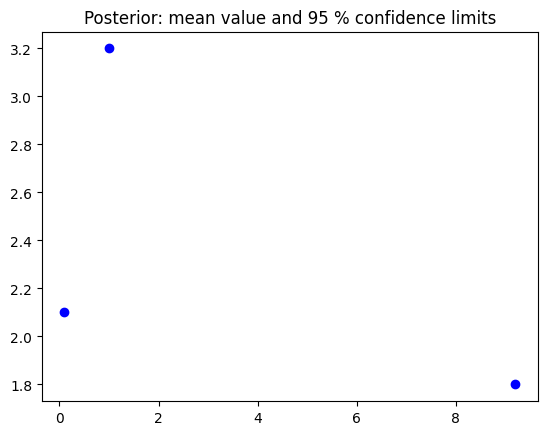

In [78]:
# Posterior
# ---------
plt.figure(2)
model.fit(X_D, Y_D)
print('score = ',model.score(X_D, Y_D))
params = model.kernel_.get_params()
print('params:',params)
plt.plot(x_D,y_D,'bo')
plt.title('Posterior: mean value and 95 % confidence limits')

After that, we are going to look at the regression result in the range that we care about, which is X_ext

In [79]:
y_ext, std = model.predict(X_ext, return_std=True)
#print(y_ext.shape)
#print(std.shape)

Here, we can see the result of the regression

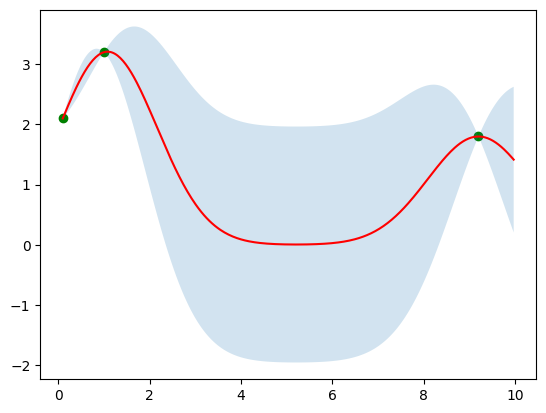

In [80]:
plt.figure(3)
plt.plot(x_ext,y_ext,'r-')
plt.scatter(x_D,y_D,color = 'green')
plt.fill_between(x_ext, y_ext - 1.96*std, y_ext + 1.96*std, alpha=0.2) # 95 % confidence limits 

plt.show()

### 2. Why does the mean function go to zero between the second and third data point?

As we can see, the second and the third point quite far away. As we tested earlier, the prior function is $y(x) = 0$. It means that our model assumed that the function should be close to $y(x) = 0$, and modifying it accordingly as we train it with new data points.

Because the second and the third point are far away from each other, the function doesn't have enough data samples. Which is the reason why it's approaching the prior function.

### 3. After all this work your boss walks in and says “the result should be close to the curve $y = \sin(x) + 2$”. That changes the prior to a new value. Modify the code and repeat the calculation. Hint: rather than modifying the underlying sklearn.GaussianProcessRegressor, write a function

In [81]:
def mod_prior(x):
    return np.sin(x) + 2

and subtract the oscillation mod_prior(x) from the three data points.
Proceed with GPR as usual. After all is done, add back oscillation to all
results and plot them as earlier. Only thing you have to pay attention to
is what y’s to modify with what input x’s to mod_prior(x). There are
array shapes (51,) and (51,1) around...

First, I'm going to substract y_D with the prior

In [82]:
# substracted with the prior
y_D_norm = y_D - mod_prior(x_D)
Y_D_norm = y_D_norm[:, np.newaxis]


Create another model using the same kernel

In [83]:
model2 = gp.GaussianProcessRegressor(kernel=kernel)

Train the model

In [84]:
model2.fit(X_D,Y_D_norm)

GaussianProcessRegressor(kernel=RBF(length_scale=1))

Next, we are going to get the regression result and the standard deviation

In [85]:
y_ext_norm, std_norm = model2.predict(X_ext, return_std = True)

# Return the oscillating part
y_osc = y_ext_norm + mod_prior(x_ext)

Now, we are going to plot the result of the regression

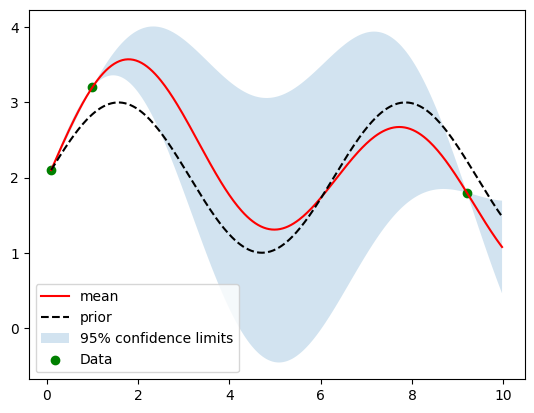

In [86]:
plt.figure(4)
plt.plot(x_ext, y_osc, 'r-', label = "mean")
plt.plot(x_ext, mod_prior(x_ext), '--', color = 'black', label = 'prior')
plt.fill_between(x_ext, y_osc - 1.96*std_norm, y_osc + 1.96*std_norm, alpha = 0.2, label = "95% confidence limits")
plt.scatter(x_D,y_D, color = 'green', label = "Data")
plt.legend()

### 4. Voluntary: Try out the parameter alpha in sklearn GaussianProcessRegressor. Setting it to a small value adds noise to the fitting procedure.

From the documentation, we see that the variable alpha is tha value added to the diagonal of the kernel matrix. We are going to see how it affects our model. I set alpha to 1e-1 instead of the default 1e-10

In [87]:
# Build another model
model3 = gp.GaussianProcessRegressor(kernel=kernel, alpha=1e-1) 

Train model

In [88]:
model3.fit(X_D,Y_D_norm)

GaussianProcessRegressor(alpha=0.1, kernel=RBF(length_scale=1))

Acquire the regression result and std

In [89]:
y_ext_norm, std_norm = model3.predict(X_ext, return_std = True)

# Return the oscillating part
y_osc = y_ext_norm + mod_prior(x_ext)

Plot the result

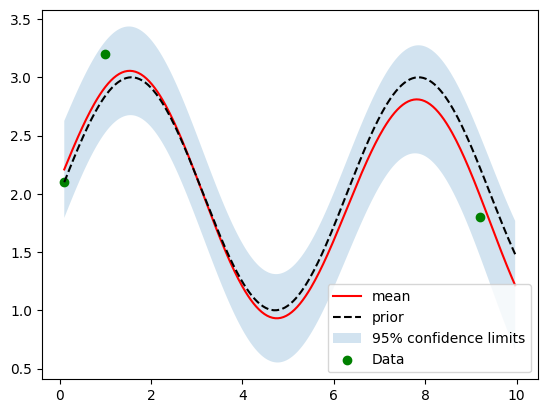

In [90]:
plt.figure(5)
plt.plot(x_ext, y_osc, 'r-', label = "mean")
plt.plot(x_ext, mod_prior(x_ext), '--', color = 'black', label = 'prior')
plt.fill_between(x_ext, y_osc - 1.96*std_norm, y_osc + 1.96*std_norm, alpha = 0.2, label = "95% confidence limits")
plt.scatter(x_D,y_D, color = 'green', label = "Data")
plt.legend()

From there, we can see that the larger alpha is, the closer the result to the prior function

### 5. Voluntary: What happens if the second point x is close to the first one? Why do you get messy results?

In [91]:
# Define new data
y_close = np.array([2.1,3.2,1.8])
x_close = np.array([0.1,0.5,9.2])
X_close = x_close[:,np.newaxis]

In [92]:
# substracted with the prior
y_close_norm = y_close - mod_prior(x_close)
Y_close_norm = y_close_norm[:, np.newaxis]

create model

In [93]:
model4 = gp.GaussianProcessRegressor(kernel=kernel, alpha=1e-10)

In [94]:
model4.fit(X_close, Y_close_norm)

GaussianProcessRegressor(kernel=RBF(length_scale=1))

Acquire result and turn it back with the oscillation factor

In [95]:
y_ext_norm, std_norm = model4.predict(X_ext, return_std = True)

# Return the oscillating part
y_osc = y_ext_norm + mod_prior(x_ext)

Plotting

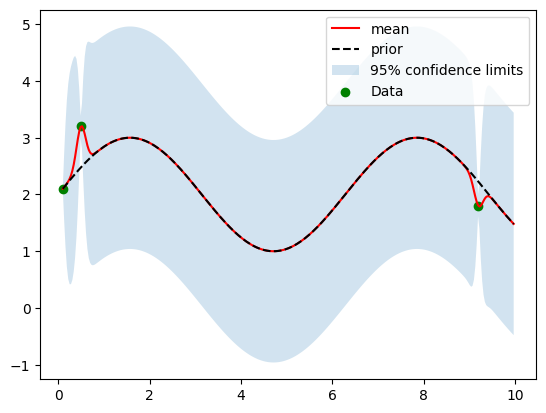

In [96]:
plt.figure(6)
plt.plot(x_ext, y_osc, 'r-', label = "mean")
plt.plot(x_ext, mod_prior(x_ext), '--', color = 'black', label = 'prior')
plt.fill_between(x_ext, y_osc - 1.96*std_norm, y_osc + 1.96*std_norm, alpha = 0.2, label = "95% confidence limits")
plt.scatter(x_close,y_close, color = 'green', label = "Data")
plt.legend()

As we can see, the changes in y is too extreme, it's hard for the model to create a smooth curve. Because of that, we can see that there's an overfitting happening in the graph, where the third datapoint is also affected by this overfitting.